In [1]:
import os
# MuJoCo use EGL
os.environ['LD_PRELOAD'] = '/usr/lib/x86_64-linux-gnu/libGLEW.so'
os.environ['MUJOCO_GL']  = 'egl'


In [2]:
# Configure MuJoCo to use the EGL rendering backend (requires GPU).
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [3]:
import robonata
import robonata.utils

import numpy as np
import matplotlib.pyplot as plt
import PIL.ImageDraw

from dm_control import mujoco
from dm_control import mjcf

from dm_control.mujoco.wrapper import mjbindings
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib
from dm_control.mujoco.wrapper.core import MjvOption


from PIL import Image
from IPython.display import display

In [4]:
# Frame size and camera name-to-idx mapping for rendering.
frame_size = {'width': 640, 'height': 480}

dragonfly_path = os.path.dirname(robonata.__file__)
xml_path = os.path.join(dragonfly_path, 'dragonfly/dragonfly_cgs1.xml')

physics = mjcf.Physics.from_xml_path(xml_path)  # Load and compile.

print('# of bodies:', physics.model.nbody)
print('# of degrees of freedom:', physics.model.nv)
print('# of joints:', physics.model.njnt)
print('# of actuators:', physics.model.nu)
print("fly's mass (gr):", physics.model.body_subtreemass[1])

# of bodies: 26
# of degrees of freedom: 22
# of joints: 17
# of actuators: 16
fly's mass (gr): 0.32430051047490094


In [5]:
opt = mujoco.wrapper.core.MjvOption()  # default geomgroup[0]=1, others=0
opt.geomgroup[3] = 1                   # turn on group3 (wings: FSI) ellipsoids
opt.geomgroup[4] = 1                   # turn on group4 (body: collision) ellipsoids
opt.geomgroup[5] = 0   # test

#this block controls which body parts group is shown when visualizing

## Load with floor and visualize
We can also load the dragonfly model combined with a simple flat floor (and a skybox) to make more physically meaningful simulations

In [6]:
xml_path_floor = os.path.join(dragonfly_path, 'dragonfly/floor.xml')

physics = mjcf.Physics.from_xml_path(xml_path_floor)    # Load floor and compile.


In [7]:
from mujoco import MjModel, MjData
# MjModel and MjData are two main classes for model definitions and simulate state

In [8]:
dragonfly_model = MjModel.from_xml_path(xml_path)
# build MuJoCo model (geometry, joints, actuators, gravity, etc.) based on .mjcf file.

data  = MjData(dragonfly_model)
# Allocates simulation state (pos, velo, forces) for that model.

In [9]:
print(f"simulation timestep = {dragonfly_model.opt.timestep}  s")

simulation timestep = 0.0001  s


In [10]:

print(f"Initial thorax Z-coord (release height) = {data.qpos[2]: .3f} cm")

Initial thorax Z-coord (release height) =  0.000 cm


In [11]:

data.qpos[2] = 0.0     # reset Z-coord of the free joint (thorax COM)
# Places the thorax COM at Z = 0 m
data.qvel[:] = 0.0     # zero out all generalized velocities
# Resets all velocities (including rotational) to zero so it drops from rest

# q means "generalized coordinate", same as the analytic mechanics

In [12]:
mujoco.mj_forward(dragonfly_model, data)  # re-compute derived quantities

# Updates MuJoCo’s internal caches (positions of all geoms, 
# centers of mass, etc.) after you manually changed qpos.

In [13]:
# Step the simulation

# Stop when the thorax COM reaches the floor plane: z <= -15 (cm)

# NOTE * EVEN YOU use CGS unit system when defining the model , 
# you should use the SI unit to do the dynamic simulation here 

z_floor = -15
t_final = 0.25               # safety bound (seconds)
dt      = dragonfly_model.opt.timestep

In [14]:
t_history = []
z_history = []

# Prepare two Python lists to record time vs. height.

In [15]:
from dm_control.mujoco import wrapper as mjcore

### Initialize Gamma angle

In [16]:
gammaForewing = np.deg2rad(8)  # approx 18 deg
gammaHindwing = 0.0  # approx 0 deg

In [17]:

FL_gamma_jid = physics.model.name2id('wingFL_gamma_hinge', 'joint')
qpos_FL_gamma_idx = physics.model.jnt_qposadr[FL_gamma_jid]
physics.data.qpos[qpos_FL_gamma_idx] = -gammaForewing

FR_gamma_jid = physics.model.name2id('wingFR_gamma_hinge', 'joint')
qpos_FR_gamma_idx = physics.model.jnt_qposadr[FR_gamma_jid]
physics.data.qpos[qpos_FR_gamma_idx] = gammaForewing

BL_gamma_jid = physics.model.name2id('wingBL_gamma_hinge', 'joint')
qpos_BL_gamma_idx = physics.model.jnt_qposadr[BL_gamma_jid]
physics.data.qpos[qpos_BL_gamma_idx] = -gammaHindwing

BR_gamma_jid = physics.model.name2id('wingBR_gamma_hinge', 'joint')
qpos_BR_gamma_idx = physics.model.jnt_qposadr[BR_gamma_jid]
physics.data.qpos[qpos_BR_gamma_idx] = gammaHindwing
physics.after_reset() 

### Initialize Beta angle (wing stroke-plane inclination)

In [18]:
# For hovering flight
betaFL_hover = np.deg2rad(51)  # approx 51 deg, four-wing-same, for hovering flight
betaFR_hover = np.deg2rad(51)  # approx 51 deg

betaBL_hover = np.deg2rad(51)  # approx 51 deg
betaBR_hover = np.deg2rad(51)  # approx 51 deg

In [19]:
# For Recovery flight
betaFL_recover = np.deg2rad(70)  # approx 70 deg, four-wing-same, for recovery flight
betaFR_recover = np.deg2rad(70)  # approx 70 deg

betaBL_recover = np.deg2rad(70)  # approx 70 deg
betaBR_recover = np.deg2rad(70)  # approx 70 deg

### Stroke angle Coefficients (flapping amplitude, phi)

In [20]:
# For hovering flight
stroke_amp_FL_hover = np.deg2rad(20.7)  # (phi_a) approx 20.7 deg, for hovering
stroke_amp_FR_hover = np.deg2rad(20.7) 

stroke_amp_BL_hover = np.deg2rad(22.12)  # approx 22.12 deg, for hindwings
stroke_amp_BR_hover = np.deg2rad(22.12)  # 

stroke_m_FL_hover = np.deg2rad(0.0)  # i.e. (phi_m, offset)
stroke_m_FR_hover = np.deg2rad(0.0) 

stroke_m_BL_hover = np.deg2rad(0.0)  # 
stroke_m_BR_hover = np.deg2rad(0.0)  # 

# For hovering flight
delta_phi_BL_hover = np.deg2rad(190)   # phase difference between forewing and hindwing
delta_phi_BR_hover = np.deg2rad(190) 


### Initialize Stroke angle (initial position, pre-cauculated, wing-stroke)

In [21]:
# For hovering flight
stroke_init_FL_hover = stroke_m_FL_hover  
    # phi_initial
stroke_init_FR_hover = stroke_m_FR_hover 

stroke_init_BL_hover = stroke_amp_BL_hover * np.sin(delta_phi_BL_hover)+stroke_m_BL_hover
stroke_init_BR_hover = stroke_amp_BR_hover * np.sin(delta_phi_BR_hover)+stroke_m_BR_hover




In [22]:
print(stroke_init_BR_hover)

-0.06703980158111761


In [23]:
# For Recovery flight
# strokeFL_recover = np.deg2rad(70)  # approx 70 deg, four-wing-same, for recovery flight
# strokeFR_recover = np.deg2rad(70)  # approx 70 deg

# strokeBL_recover = np.deg2rad(70)  # approx 70 deg
# strokeBR_recover = np.deg2rad(70)  # approx 70 deg

### Pitch angle Coefficients (wing psi)

In [24]:
# For hovering flight
pitch_amp_FL_hover = np.deg2rad(50)  # (psi_a) approx 20.7 deg, for hovering
pitch_amp_FR_hover = np.deg2rad(50) 

pitch_amp_BL_hover = np.deg2rad(50)  # approx 22.12 deg, for hindwings
pitch_amp_BR_hover = np.deg2rad(50)  # 

pitch_m_FL_hover = np.deg2rad(120)  # i.e. (psi_m, offset)
pitch_m_FR_hover = np.deg2rad(120) 

pitch_m_BL_hover = np.deg2rad(120)  # 
pitch_m_BR_hover = np.deg2rad(120)  # 

# For hovering flight
delta_psi_FL_hover = np.deg2rad(95)   # phase difference between forewing and hindwing
delta_psi_FR_hover = np.deg2rad(95) 
delta_psi_BL_hover = np.deg2rad(95)   # phase difference between forewing and hindwing
delta_psi_BR_hover = np.deg2rad(95) 


### Initialize Pitch angle (initial position, pre-cauculated, wing-stroke)

In [25]:
# For hovering flight
pitch_init_FL_hover = pitch_amp_FL_hover * np.sin(delta_psi_FL_hover)+pitch_m_FL_hover
    # psi_initial
pitch_init_FR_hover = pitch_amp_FR_hover * np.sin(delta_psi_FR_hover)+pitch_m_FR_hover

pitch_init_BL_hover = pitch_amp_BL_hover * np.sin(delta_phi_BL_hover + delta_psi_BL_hover) + pitch_m_BL_hover
pitch_init_BR_hover = pitch_amp_BR_hover * np.sin(delta_phi_BR_hover + delta_psi_BR_hover) + pitch_m_BR_hover



In [26]:
print(np.rad2deg(pitch_init_FL_hover))

169.80973490458726


In [27]:
print(np.rad2deg(pitch_init_BL_hover))

71.70370868554657


### Initialize Sinusoidal parameters

In [28]:
freq  = 40     # Hz (Constant for most dragonfly)

In [29]:
# while data.time < t_final:
#     t_history.append(data.time)
#     z_history.append(data.qpos[2])
    
#     # Break if COM touches the floor or goes below
#     if data.qpos[2] <= z_floor:
#         break
    
#     mujoco.mj_step(dragonfly_model, data)


In [30]:

# print(f"Impact at t = {data.time:.4f}  s,  z = {data.qpos[2]:.4f}  cm")


### Plot the trajectory

In [31]:
# plt.figure(figsize=(5,4))


In [32]:
# plt.plot(t_history, z_history)
# here we get the CoM traj during free-fall

In [33]:
# plt.figure(figsize=(7,5))
# plt.xlabel('time  [s]')
# plt.ylabel('thorax COM height  [cm]')
# plt.title('Free-drop of dragonfly')
# plt.grid(True)
# #plt.legend()
# plt.plot(t_history, z_history)
# plt.show()

## Animation

In [34]:
n_steps = 200
physics_to_ctrl_ratio = 10
cam0_frames = []

# Reset physics to initial default state.
physics.reset()

#++++++++++++++++++++++
# Set gamma joint angle to initial default state.
FL_gamma_jid = physics.model.name2id('wingFL_gamma_hinge', 'joint')
qpos_FL_gamma_idx = physics.model.jnt_qposadr[FL_gamma_jid]
physics.data.qpos[qpos_FL_gamma_idx] = -gammaForewing

FR_gamma_jid = physics.model.name2id('wingFR_gamma_hinge', 'joint')
qpos_FR_gamma_idx = physics.model.jnt_qposadr[FR_gamma_jid]
physics.data.qpos[qpos_FR_gamma_idx] = gammaForewing

BL_gamma_jid = physics.model.name2id('wingBL_gamma_hinge', 'joint')
qpos_BL_gamma_idx = physics.model.jnt_qposadr[BL_gamma_jid]
physics.data.qpos[qpos_BL_gamma_idx] = -gammaHindwing

BR_gamma_jid = physics.model.name2id('wingBR_gamma_hinge', 'joint')
qpos_BR_gamma_idx = physics.model.jnt_qposadr[BR_gamma_jid]
physics.data.qpos[qpos_BR_gamma_idx] = gammaHindwing


#++++++++++++++++++++++
# Set beta joint angle to initial default state.
FL_beta_jid = physics.model.name2id('wingFL_beta_hinge', 'joint')
qpos_FL_beta_idx = physics.model.jnt_qposadr[FL_beta_jid]
physics.data.qpos[qpos_FL_beta_idx] = betaFL_hover

FR_beta_jid = physics.model.name2id('wingFR_beta_hinge', 'joint')
qpos_FR_beta_idx = physics.model.jnt_qposadr[FR_beta_jid]
physics.data.qpos[qpos_FR_beta_idx] = betaFR_hover

BL_beta_jid = physics.model.name2id('wingBL_beta_hinge', 'joint')
qpos_BL_beta_idx = physics.model.jnt_qposadr[BL_beta_jid]
physics.data.qpos[qpos_BL_beta_idx] = betaBL_hover

BR_beta_jid = physics.model.name2id('wingBR_beta_hinge', 'joint')
qpos_BR_beta_idx = physics.model.jnt_qposadr[BR_beta_jid]
physics.data.qpos[qpos_BR_beta_idx] = betaBR_hover


#++++++++++++++++++++++
# Set stroke joint angle (phi) to initial default state.
FL_stroke_jid = physics.model.name2id('wingFL_stroke_hinge', 'joint')
qpos_FL_stroke_idx = physics.model.jnt_qposadr[FL_stroke_jid]
physics.data.qpos[qpos_FL_stroke_idx] = - stroke_init_FL_hover

FR_stroke_jid = physics.model.name2id('wingFR_stroke_hinge', 'joint')
qpos_FR_stroke_idx = physics.model.jnt_qposadr[FR_stroke_jid]
physics.data.qpos[qpos_FR_stroke_idx] = -stroke_init_FR_hover
        # note that due to the positive z rotation, here flip the sign

BL_stroke_jid = physics.model.name2id('wingBL_stroke_hinge', 'joint')
qpos_BL_stroke_idx = physics.model.jnt_qposadr[BL_stroke_jid]
physics.data.qpos[qpos_BL_stroke_idx] = stroke_init_BL_hover

BR_stroke_jid = physics.model.name2id('wingBR_stroke_hinge', 'joint')
qpos_BR_stroke_idx = physics.model.jnt_qposadr[BR_stroke_jid]
physics.data.qpos[qpos_BR_stroke_idx] = -stroke_init_BR_hover


#++++++++++++++++++++++
# Set pitch joint angle (psi) to initial default state.
FL_pitch_jid = physics.model.name2id('wingFL_pitch_hinge', 'joint')
qpos_FL_pitch_idx = physics.model.jnt_qposadr[FL_pitch_jid]
physics.data.qpos[qpos_FL_pitch_idx] = - pitch_init_FL_hover

FR_pitch_jid = physics.model.name2id('wingFR_pitch_hinge', 'joint')
qpos_FR_pitch_idx = physics.model.jnt_qposadr[FR_pitch_jid]
physics.data.qpos[qpos_FR_pitch_idx] = -pitch_init_FR_hover
        # note that due to the positive z rotation, here flip all signs

BL_pitch_jid = physics.model.name2id('wingBL_pitch_hinge', 'joint')
qpos_BL_pitch_idx = physics.model.jnt_qposadr[BL_pitch_jid]
physics.data.qpos[qpos_BL_pitch_idx] = -pitch_init_BL_hover

BR_pitch_jid = physics.model.name2id('wingBR_pitch_hinge', 'joint')
qpos_BR_pitch_idx = physics.model.jnt_qposadr[BR_pitch_jid]
physics.data.qpos[qpos_BR_pitch_idx] = -pitch_init_BR_hover




#++++++++++ Update initial settings ++++++++++++
physics.after_reset() 

# ---- fetch the gamma actuator index once --------------------------------
FL_gamma_id = physics.model.name2id('wingFL_gamma_act', 'actuator')
FR_gamma_id = physics.model.name2id('wingFR_gamma_act', 'actuator')
BL_gamma_id = physics.model.name2id('wingBL_gamma_act', 'actuator')
BR_gamma_id = physics.model.name2id('wingBR_gamma_act', 'actuator')

# ---- fetch the beta actuator index once --------------------------------
FL_beta_id = physics.model.name2id('wingFL_beta_servo', 'actuator')
FR_beta_id = physics.model.name2id('wingFR_beta_servo', 'actuator')
BL_beta_id = physics.model.name2id('wingBL_beta_servo', 'actuator')
BR_beta_id = physics.model.name2id('wingBR_beta_servo', 'actuator')

# ---- fetch the wing-stroke actuator index once --------------------------------
FL_stroke_id = physics.model.name2id('wingFL_stroke_servo', 'actuator')
FR_stroke_id = physics.model.name2id('wingFR_stroke_servo', 'actuator')
BL_stroke_id = physics.model.name2id('wingBL_stroke_servo', 'actuator')
BR_stroke_id = physics.model.name2id('wingBR_stroke_servo', 'actuator')

# ---- fetch the wing-pitch actuator index once --------------------------------
FL_pitch_id = physics.model.name2id('wingFL_pitch_servo', 'actuator')
FR_pitch_id = physics.model.name2id('wingFR_pitch_servo', 'actuator')
BL_pitch_id = physics.model.name2id('wingBL_pitch_servo', 'actuator')
BR_pitch_id = physics.model.name2id('wingBR_pitch_servo', 'actuator')


# -------- Track the actual wing-angle -----
# -------------------------------------------------
t_log      = []     # simulation times

gammaFL_log = []
gammaBL_log = []

betaFL_log = []     # actual joint angles (rad)
betaBL_log = []     # actual joint angles (rad)

strokeFL_log = []     # actual joint angles (rad)
strokeBL_log = []     # actual joint angles (rad)

pitchFL_log = []     # actual joint angles (rad)
pitchBL_log = []     # actual joint angles (rad)

thorax_body = 'thorax'                               # <-- name in MJCF
com_log     = []                                     # will hold [x,y,z]


In [35]:
root_jid   = physics.model.name2id("thorax_root", "joint")      # freejoint name
root_body  = physics.model.name2id("thorax",   "body")       # main body

# qpos slice (7 numbers) and qvel slice (6 numbers) for that joint
qpos0 = physics.model.jnt_qposadr[root_jid]                  # starting address
qvel0 = physics.model.jnt_dofadr[root_jid]                   # ditto in qvel
root_qpos = slice(qpos0, qpos0 + 7)
root_qvel = slice(qvel0, qvel0 + 6)

# remember where the body‑frame wrench lives
xfrc_row = root_body                                         # one row per body

# store the initial pose so we can restore it every step
root_pose0 = physics.data.qpos[root_qpos].copy()

In [36]:
warmup_time = 0.025         # seconds

In [37]:

# Let it freedrop!
for i in range(n_steps): 
    pixels = physics.render(camera_id=0, scene_option=opt,  **frame_size)
    cam0_frames.append(pixels)
    
    for _ in range(physics_to_ctrl_ratio):
        t        = physics.data.time
        FL_beta_cmd = betaFL_hover;
        FR_beta_cmd = betaFR_hover;
        BL_beta_cmd = betaBL_hover;
        BR_beta_cmd = betaBR_hover;

        # Define control signal (for wing-stroke and wing-pitch)
        # start from horizontal position
        FL_stroke_cmd = stroke_amp_FL_hover * np.sin(2 * np.pi * freq * t) + stroke_m_FL_hover;
        FR_stroke_cmd = stroke_amp_FR_hover * np.sin(2 * np.pi * freq * t) + stroke_m_FR_hover;
        BL_stroke_cmd = stroke_amp_BL_hover * np.sin(2 * np.pi * freq * t + delta_phi_BL_hover) + stroke_m_BL_hover;
        BR_stroke_cmd = stroke_amp_FR_hover * np.sin(2 * np.pi * freq * t + delta_phi_BR_hover) + stroke_m_FR_hover;

        # Wing pitch control signal
        FL_pitch_cmd = pitch_amp_FL_hover * np.sin(2 * np.pi * freq * t + delta_psi_FL_hover) + pitch_m_FL_hover;
        FR_pitch_cmd = pitch_amp_FR_hover * np.sin(2 * np.pi * freq * t + delta_psi_FR_hover) + pitch_m_FR_hover;
        BL_pitch_cmd = pitch_amp_BL_hover * np.sin(2 * np.pi * freq * t + delta_phi_BL_hover + delta_psi_BL_hover) + pitch_m_BL_hover;
        BR_pitch_cmd = pitch_amp_FR_hover * np.sin(2 * np.pi * freq * t + delta_phi_BR_hover + delta_psi_BR_hover) + pitch_m_FR_hover;

        # Define beta-angle (wing stroke surface inclination angle, keep const)
        physics.data.ctrl[FL_beta_id] = FL_beta_cmd   # write desired beta angle (const)
        physics.data.ctrl[FR_beta_id] = FR_beta_cmd
        physics.data.ctrl[BL_beta_id] = BL_beta_cmd
        physics.data.ctrl[BR_beta_id] = BR_beta_cmd
        
        
        # control wing-stroke motion
        physics.data.ctrl[FL_stroke_id] = FL_stroke_cmd
        physics.data.ctrl[FR_stroke_id] = - FR_stroke_cmd
        physics.data.ctrl[BL_stroke_id] = BL_stroke_cmd
        physics.data.ctrl[BR_stroke_id] = - BR_stroke_cmd
                          #note that right wings need flip sign, due to Z+ direction

        # control wing-pitch motion
        physics.data.ctrl[FL_pitch_id] = - FL_pitch_cmd
        physics.data.ctrl[FR_pitch_id] = - FR_pitch_cmd
        physics.data.ctrl[BL_pitch_id] = - BL_pitch_cmd
        physics.data.ctrl[BR_pitch_id] = - BR_pitch_cmd
                         #note that all wings need to flip sign, due to Y+ direction

        
        # ---------- hold the body fixed for the first 0.05 s ---------
        if t < warmup_time:
            # keep pose frozen
            physics.data.qpos[root_qpos] = root_pose0
            # kill any base velocity the solver introduced
            physics.data.qvel[root_qvel] = 0.0
            # wipe external forces (avoids carry‑over impulses)
            physics.data.xfrc_applied[xfrc_row, :] = 0.0
        # -------------------------------------------------------------
        
        # time-update
        physics.step()

        # track the actual motion
        t_log.append(t)
        strokeFL_log.append(physics.data.qpos[qpos_FL_stroke_idx])  # rad
        strokeBL_log.append(physics.data.qpos[qpos_BL_stroke_idx])  # rad
        pitchFL_log.append(physics.data.qpos[qpos_FL_pitch_idx])  # rad
        pitchBL_log.append(physics.data.qpos[qpos_BL_pitch_idx])  # rad
        com_log.append(physics.named.data.xipos[thorax_body].copy())

In [38]:
robonata.utils.display_video(cam0_frames)

In [39]:
%matplotlib inline

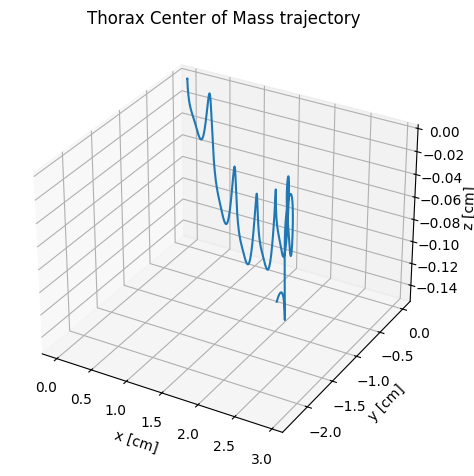

In [40]:
t   = np.asarray(t_log)          # shape (N,)
com = np.vstack(com_log)         # shape (N,3)

# --------- 3‑D trajectory (x vs y vs z) ----------
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot(com[:,0], com[:,1], com[:,2])
ax.set_xlabel('x [cm]'); ax.set_ylabel('y [cm]'); ax.set_zlabel('z [cm]')
ax.set_title('Thorax Center of Mass trajectory')
plt.tight_layout()
plt.show()

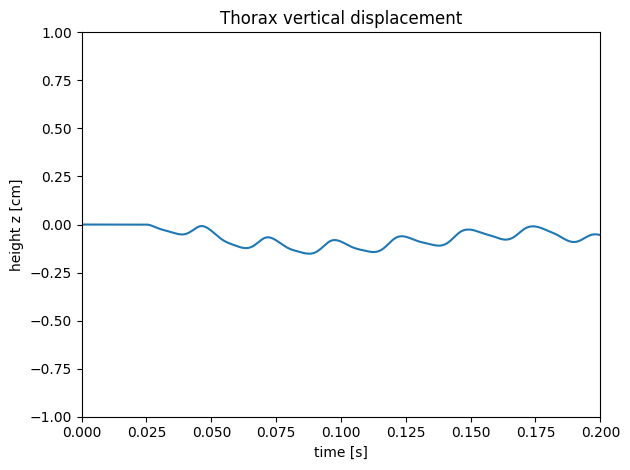

In [41]:
# --------- height (z) vs time ----------
plt.figure()
plt.plot(t, com[:,2])
plt.xlabel('time [s]')
plt.ylabel('height z [cm]')
plt.title('Thorax vertical displacement')
plt.xlim(0, 0.2)               # if you only care about the first 75 ms
plt.ylim(-1, 1) 
plt.tight_layout()
plt.show()

In [42]:
t_log      = np.asarray(t_log)
gammaFL_log = np.asarray(gammaFL_log)
gammaBL_log = np.asarray(gammaBL_log)


In [43]:
t_log      = np.asarray(t_log)
strokeFL_log = np.asarray(strokeFL_log)
strokeBL_log = np.asarray(strokeBL_log)

strokeFL_cmd = stroke_amp_FL_hover * np.sin(2*np.pi*freq*t_log) + stroke_m_FL_hover
strokeBL_cmd = stroke_amp_BL_hover * np.sin(2*np.pi*freq*t_log + delta_phi_BL_hover) + stroke_m_BL_hover


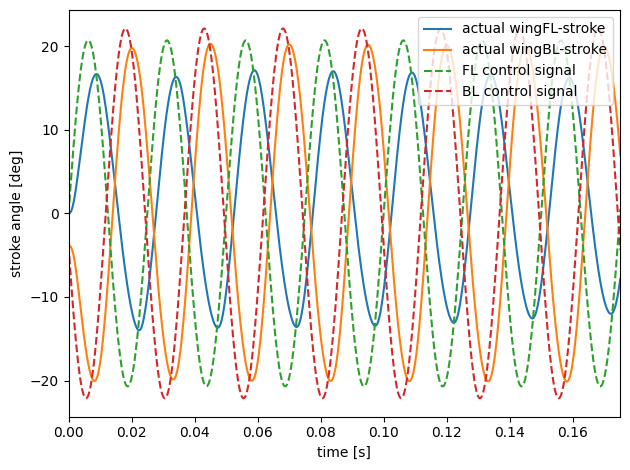

In [44]:

plt.plot(t_log, np.rad2deg(strokeFL_log),      label='actual wingFL-stroke')
plt.plot(t_log, np.rad2deg(strokeBL_log),      label='actual wingBL-stroke')
plt.plot(t_log, np.rad2deg(strokeFL_cmd), '--', label='FL control signal')
plt.plot(t_log, np.rad2deg(strokeBL_cmd), '--', label='BL control signal')

plt.xlim(0, 0.175) 

plt.xlabel('time [s]')
plt.ylabel('stroke angle [deg]')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [45]:
t_log      = np.asarray(t_log)
pitchFL_log = np.asarray(pitchFL_log)
pitchBL_log = np.asarray(pitchBL_log)

pitchFL_cmd = pitch_amp_FL_hover * np.sin(2*np.pi*freq*t_log + delta_psi_FL_hover) + pitch_m_FL_hover
pitchBL_cmd = pitch_amp_BL_hover * np.sin(2*np.pi*freq*t_log + delta_phi_BL_hover + delta_psi_BL_hover) + pitch_m_BL_hover


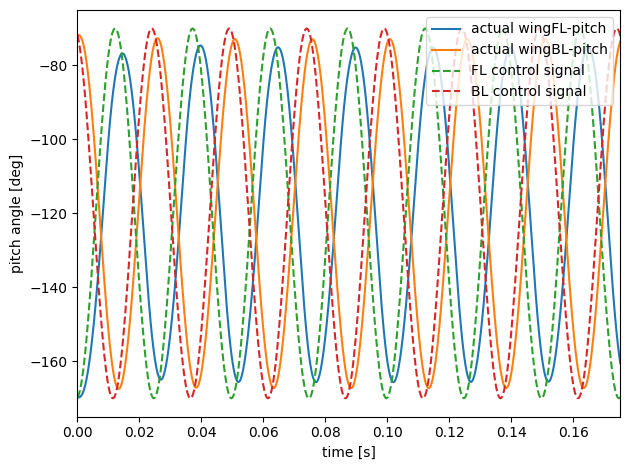

In [46]:

plt.plot(t_log, np.rad2deg(pitchFL_log),      label='actual wingFL-pitch')
plt.plot(t_log, np.rad2deg(pitchBL_log),      label='actual wingBL-pitch')
plt.plot(t_log, np.rad2deg(-pitchFL_cmd), '--', label='FL control signal')
plt.plot(t_log, np.rad2deg(-pitchBL_cmd), '--', label='BL control signal')

plt.xlim(0, 0.175) 

plt.xlabel('time [s]')
plt.ylabel('pitch angle [deg]')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [54]:
n_steps = 200
physics_to_ctrl_ratio = 10
cam1_frames = []

# Reset physics to initial default state.
physics.reset()

#++++++++++++++++++++++
# Set gamma joint angle to initial default state.
FL_gamma_jid = physics.model.name2id('wingFL_gamma_hinge', 'joint')
qpos_FL_gamma_idx = physics.model.jnt_qposadr[FL_gamma_jid]
physics.data.qpos[qpos_FL_gamma_idx] = -gammaForewing

FR_gamma_jid = physics.model.name2id('wingFR_gamma_hinge', 'joint')
qpos_FR_gamma_idx = physics.model.jnt_qposadr[FR_gamma_jid]
physics.data.qpos[qpos_FR_gamma_idx] = gammaForewing

BL_gamma_jid = physics.model.name2id('wingBL_gamma_hinge', 'joint')
qpos_BL_gamma_idx = physics.model.jnt_qposadr[BL_gamma_jid]
physics.data.qpos[qpos_BL_gamma_idx] = -gammaHindwing

BR_gamma_jid = physics.model.name2id('wingBR_gamma_hinge', 'joint')
qpos_BR_gamma_idx = physics.model.jnt_qposadr[BR_gamma_jid]
physics.data.qpos[qpos_BR_gamma_idx] = gammaHindwing


#++++++++++++++++++++++
# Set beta joint angle to initial default state.
FL_beta_jid = physics.model.name2id('wingFL_beta_hinge', 'joint')
qpos_FL_beta_idx = physics.model.jnt_qposadr[FL_beta_jid]
physics.data.qpos[qpos_FL_beta_idx] = betaFL_hover

FR_beta_jid = physics.model.name2id('wingFR_beta_hinge', 'joint')
qpos_FR_beta_idx = physics.model.jnt_qposadr[FR_beta_jid]
physics.data.qpos[qpos_FR_beta_idx] = betaFR_hover

BL_beta_jid = physics.model.name2id('wingBL_beta_hinge', 'joint')
qpos_BL_beta_idx = physics.model.jnt_qposadr[BL_beta_jid]
physics.data.qpos[qpos_BL_beta_idx] = betaBL_hover

BR_beta_jid = physics.model.name2id('wingBR_beta_hinge', 'joint')
qpos_BR_beta_idx = physics.model.jnt_qposadr[BR_beta_jid]
physics.data.qpos[qpos_BR_beta_idx] = betaBR_hover


#++++++++++++++++++++++
# Set stroke joint angle (phi) to initial default state.
FL_stroke_jid = physics.model.name2id('wingFL_stroke_hinge', 'joint')
qpos_FL_stroke_idx = physics.model.jnt_qposadr[FL_stroke_jid]
physics.data.qpos[qpos_FL_stroke_idx] = - stroke_init_FL_hover

FR_stroke_jid = physics.model.name2id('wingFR_stroke_hinge', 'joint')
qpos_FR_stroke_idx = physics.model.jnt_qposadr[FR_stroke_jid]
physics.data.qpos[qpos_FR_stroke_idx] = -stroke_init_FR_hover
        # note that due to the positive z rotation, here flip the sign

BL_stroke_jid = physics.model.name2id('wingBL_stroke_hinge', 'joint')
qpos_BL_stroke_idx = physics.model.jnt_qposadr[BL_stroke_jid]
physics.data.qpos[qpos_BL_stroke_idx] = stroke_init_BL_hover

BR_stroke_jid = physics.model.name2id('wingBR_stroke_hinge', 'joint')
qpos_BR_stroke_idx = physics.model.jnt_qposadr[BR_stroke_jid]
physics.data.qpos[qpos_BR_stroke_idx] = -stroke_init_BR_hover


#++++++++++++++++++++++
# Set pitch joint angle (psi) to initial default state.
FL_pitch_jid = physics.model.name2id('wingFL_pitch_hinge', 'joint')
qpos_FL_pitch_idx = physics.model.jnt_qposadr[FL_pitch_jid]
physics.data.qpos[qpos_FL_pitch_idx] = - pitch_init_FL_hover

FR_pitch_jid = physics.model.name2id('wingFR_pitch_hinge', 'joint')
qpos_FR_pitch_idx = physics.model.jnt_qposadr[FR_pitch_jid]
physics.data.qpos[qpos_FR_pitch_idx] = -pitch_init_FR_hover
        # note that due to the positive z rotation, here flip all signs

BL_pitch_jid = physics.model.name2id('wingBL_pitch_hinge', 'joint')
qpos_BL_pitch_idx = physics.model.jnt_qposadr[BL_pitch_jid]
physics.data.qpos[qpos_BL_pitch_idx] = -pitch_init_BL_hover

BR_pitch_jid = physics.model.name2id('wingBR_pitch_hinge', 'joint')
qpos_BR_pitch_idx = physics.model.jnt_qposadr[BR_pitch_jid]
physics.data.qpos[qpos_BR_pitch_idx] = -pitch_init_BR_hover




#++++++++++ Update initial settings ++++++++++++
physics.after_reset() 

# ---- fetch the beta actuator index once --------------------------------
FL_beta_id = physics.model.name2id('wingFL_beta_servo', 'actuator')
FR_beta_id = physics.model.name2id('wingFR_beta_servo', 'actuator')
BL_beta_id = physics.model.name2id('wingBL_beta_servo', 'actuator')
BR_beta_id = physics.model.name2id('wingBR_beta_servo', 'actuator')

# ---- fetch the wing-stroke actuator index once --------------------------------
FL_stroke_id = physics.model.name2id('wingFL_stroke_servo', 'actuator')
FR_stroke_id = physics.model.name2id('wingFR_stroke_servo', 'actuator')
BL_stroke_id = physics.model.name2id('wingBL_stroke_servo', 'actuator')
BR_stroke_id = physics.model.name2id('wingBR_stroke_servo', 'actuator')

# ---- fetch the wing-pitch actuator index once --------------------------------
FL_pitch_id = physics.model.name2id('wingFL_pitch_servo', 'actuator')
FR_pitch_id = physics.model.name2id('wingFR_pitch_servo', 'actuator')
BL_pitch_id = physics.model.name2id('wingBL_pitch_servo', 'actuator')
BR_pitch_id = physics.model.name2id('wingBR_pitch_servo', 'actuator')


# -------- Track the actual wing-angle -----
# -------------------------------------------------
t_log      = []     # simulation times
strokeFL_log = []     # actual joint angles (rad)
strokeBL_log = []     # actual joint angles (rad)

pitchFL_log = []     # actual joint angles (rad)
pitchBL_log = []     # actual joint angles (rad)


# Let it freedrop!
for i in range(n_steps): 
    pixels = physics.render(camera_id=1, scene_option=opt,  **frame_size)
    cam1_frames.append(pixels)
    
    for _ in range(physics_to_ctrl_ratio):
        t        = physics.data.time
        FL_beta_cmd = betaFL_hover;
        FR_beta_cmd = betaFR_hover;
        BL_beta_cmd = betaBL_hover;
        BR_beta_cmd = betaBR_hover;

        # Define control signal (for wing-stroke and wing-pitch)
        # start from horizontal position
        FL_stroke_cmd = stroke_amp_FL_hover * np.sin(2 * np.pi * freq * t) + stroke_m_FL_hover;
        FR_stroke_cmd = stroke_amp_FR_hover * np.sin(2 * np.pi * freq * t) + stroke_m_FR_hover;
        BL_stroke_cmd = stroke_amp_BL_hover * np.sin(2 * np.pi * freq * t + delta_phi_BL_hover) + stroke_m_BL_hover;
        BR_stroke_cmd = stroke_amp_FR_hover * np.sin(2 * np.pi * freq * t + delta_phi_BR_hover) + stroke_m_FR_hover;

        # Wing pitch control signal
        FL_pitch_cmd = pitch_amp_FL_hover * np.sin(2 * np.pi * freq * t + delta_psi_FL_hover) + pitch_m_FL_hover;
        FR_pitch_cmd = pitch_amp_FR_hover * np.sin(2 * np.pi * freq * t + delta_psi_FR_hover) + pitch_m_FR_hover;
        BL_pitch_cmd = pitch_amp_BL_hover * np.sin(2 * np.pi * freq * t + delta_phi_BL_hover + delta_psi_BL_hover) + pitch_m_BL_hover;
        BR_pitch_cmd = pitch_amp_FR_hover * np.sin(2 * np.pi * freq * t + delta_phi_BR_hover + delta_psi_BR_hover) + pitch_m_FR_hover;

        # Define beta-angle (wing stroke surface inclination angle, keep const)
        physics.data.ctrl[FL_beta_id] = FL_beta_cmd   # write desired beta angle (const)
        physics.data.ctrl[FR_beta_id] = FR_beta_cmd
        physics.data.ctrl[BL_beta_id] = BL_beta_cmd
        physics.data.ctrl[BR_beta_id] = BR_beta_cmd
        
        
        # control wing-stroke motion
        physics.data.ctrl[FL_stroke_id] = FL_stroke_cmd
        physics.data.ctrl[FR_stroke_id] = - FR_stroke_cmd
        physics.data.ctrl[BL_stroke_id] = BL_stroke_cmd
        physics.data.ctrl[BR_stroke_id] = - BR_stroke_cmd
                          #note that right wings need flip sign, due to Z+ direction

        # control wing-pitch motion
        physics.data.ctrl[FL_pitch_id] = - FL_pitch_cmd
        physics.data.ctrl[FR_pitch_id] = - FR_pitch_cmd
        physics.data.ctrl[BL_pitch_id] = - BL_pitch_cmd
        physics.data.ctrl[BR_pitch_id] = - BR_pitch_cmd
                         #note that all wings need to flip sign, due to Y+ direction

        
        # time-update
        physics.step()

        # track the actual motion
        t_log.append(t)
        strokeFL_log.append(physics.data.qpos[qpos_FL_stroke_idx])  # rad
        strokeBL_log.append(physics.data.qpos[qpos_BL_stroke_idx])  # rad
        pitchFL_log.append(physics.data.qpos[qpos_FL_pitch_idx])  # rad
        pitchBL_log.append(physics.data.qpos[qpos_BL_pitch_idx])  # rad
        

In [55]:
robonata.utils.display_video(cam1_frames)

In [56]:
t_log      = np.asarray(t_log)
pitchFL_log = np.asarray(pitchFL_log)
pitchBL_log = np.asarray(pitchBL_log)

pitchFL_cmd = pitch_amp_FL_hover * np.sin(2*np.pi*freq*t_log + delta_psi_FL_hover) + pitch_m_FL_hover
pitchBL_cmd = pitch_amp_BL_hover * np.sin(2*np.pi*freq*t_log + delta_phi_BL_hover + delta_psi_BL_hover) + pitch_m_BL_hover


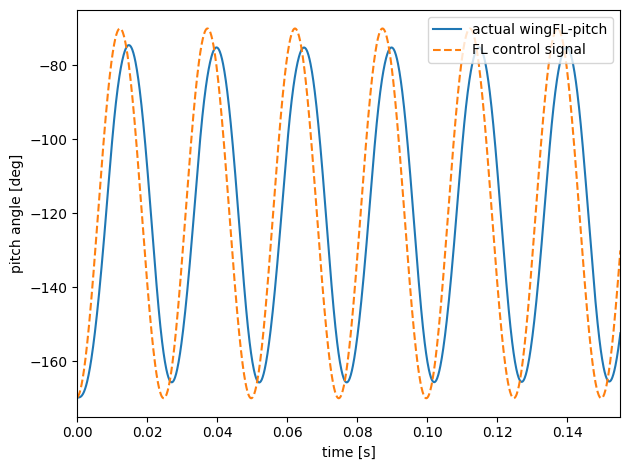

In [57]:

plt.plot(t_log, np.rad2deg(pitchFL_log),      label='actual wingFL-pitch')
#plt.plot(t_log, np.rad2deg(pitchBL_log),      label='actual wingBL-pitch')
plt.plot(t_log, np.rad2deg(-pitchFL_cmd), '--', label='FL control signal')
#plt.plot(t_log, np.rad2deg(pitchBL_cmd), '--', label='BL control signal')

plt.xlim(0, 0.155) 

plt.xlabel('time [s]')
plt.ylabel('pitch angle [deg]')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()